## Embedding Downstream Task Tutorial (HLS Burn Scars Data)

This notebook demonstrates how to use EO embeddings for downstream tasks in TerraTorch. TerraTorch supports **no-code and low-code embedding downstream tasks** via the `IdentityBackbone`. Below, we showcase this workflow on the HLS Burn Scars dataset.

To follow this tutorial, you first need to generate and save embeddings using the `embedding_generation_burnscars.ipynb` notebook. Please complete steps **1–4** of that notebook so that you have embeddings available locally.



In [ ]:
import torch
import terratorch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
import albumentations
import warnings
warnings.filterwarnings('ignore')

### 1. Checking data

This notebook requires downloaded HLS Burnscars Labels, as well as precomputed embeddings.

In [2]:
root = Path("hls_burn_scars")
dataset_path = root / "data"
embedding_path = root / "embeddings_terramind" / "layer_00"

ok = True
msgs = []

if not dataset_path.is_dir():
    ok = False
    msgs.append(f"- Dataset path not found: {dataset_path}")

if not embedding_path.is_dir():
    ok = False
    msgs.append(f"- Embedding path not found: {embedding_path}")

dataset_files = list(dataset_path.glob("*_merged.tif")) if dataset_path.is_dir() else []
embedding_files = list(embedding_path.glob("*_embedding.tif")) if embedding_path.is_dir() else []

if len(dataset_files) != 804:
    ok = False
    msgs.append(f"- Expected 804 dataset files (*_merged.tif), found {len(dataset_files)}")

if len(embedding_files) != 804:
    ok = False
    msgs.append(f"- Expected 804 embedding files (*_embedding.tif), found {len(embedding_files)}")

if ok:
    print("Data available.")
else:
    raise RuntimeError(
        "Required data not found or incomplete.\n"
        + "\n".join(msgs)
        + "\n\nPlease check the paths and otherwise go to "
        "`embedding_generation_burnscars.ipynb` to download the required data and generate embeddings."
    )

Data available.


### 2. Get Datamodule

For embeddings saved as individual GeoTIFF files, we can use a standard TerraTorch datamodule to load the data. We point the label root to the HLS Burn Scars labels and use the original train/val/test split files.

We do not pass any mean or standard deviation values, which skips normalization of the embeddings. We also set the flag `embedding_input=True`, which is used for visualization purposes. Apart from these differences, the datamodule is configured in the same way as for raw imagery, e.g. we still apply training transforms to help stabilize training.

In [3]:
from terratorch.datamodules import GenericNonGeoSegmentationDataModule

datamodule = GenericNonGeoSegmentationDataModule(
    batch_size=8,
    num_workers=2,
    num_classes=2,

    # Define dataset paths
    train_data_root= embedding_path,
    train_label_data_root= dataset_path,
    val_data_root= embedding_path,
    val_label_data_root= dataset_path,
    test_data_root= embedding_path,
    test_label_data_root= dataset_path,

    img_grep='*_embedding.tif',
    label_grep='*.mask.tif',

    # Define splits
    train_split=root / 'splits/train.txt',
    val_split=root / 'splits/val.txt',
    test_split=root / 'splits/test.txt',


    no_label_replace=-1,
    embedding_input=True, # Set this flag for embedding inputs, will be used for visualisations.

    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
)

# Setup train and val datasets
datamodule.setup("fit")

Length training dataset: 524


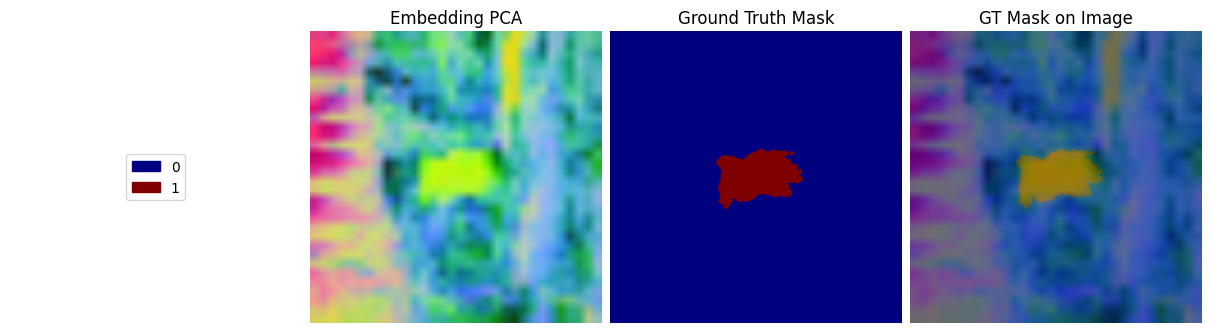

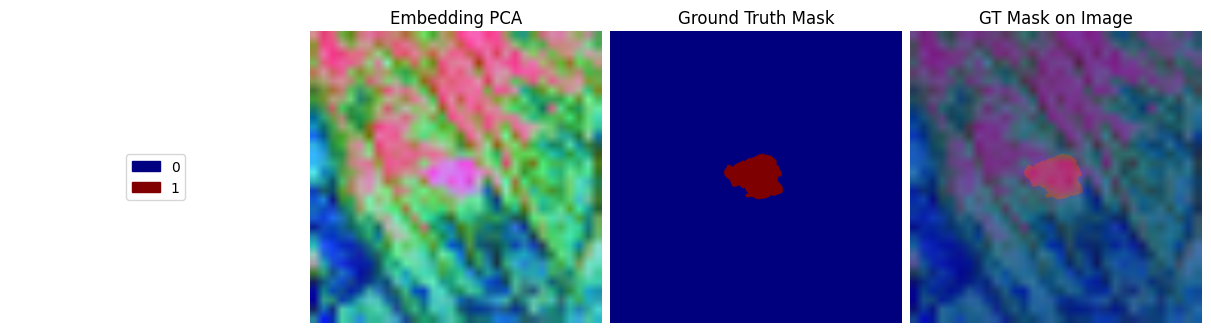

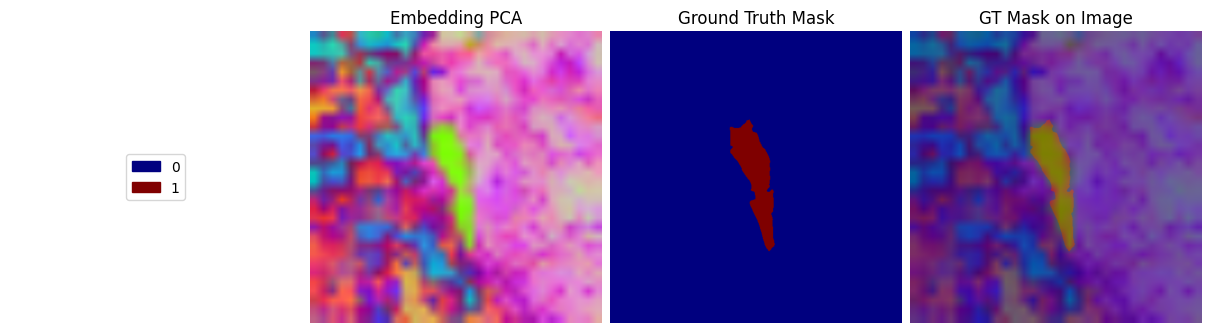

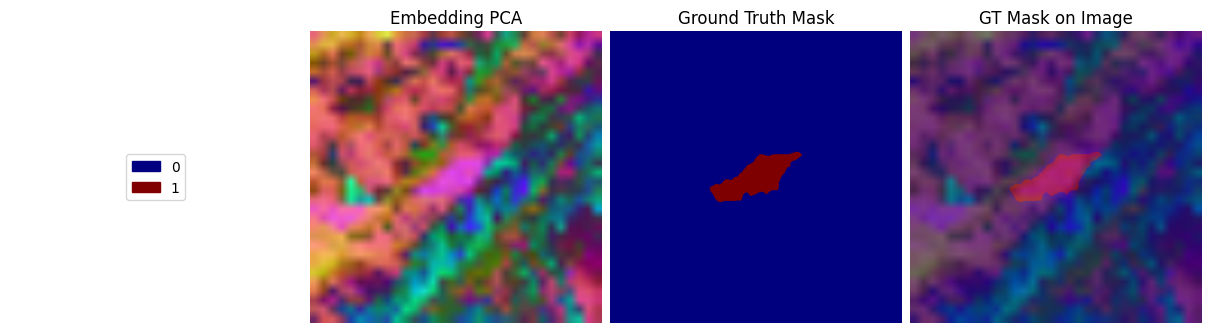

In [4]:
# We inspect some samples
train_dataset = datamodule.train_dataset
print(f"Length training dataset: {len(train_dataset)}")

_ = train_dataset.plot(train_dataset[0])
_ = train_dataset.plot(train_dataset[2])
_ = train_dataset.plot(train_dataset[3])
_ = train_dataset.plot(train_dataset[4])

### 2. Set Up Task

We initialize a TerraTorch task in the same way as for workflows that operate on raw images. However, instead of using a backbone, we use the `IdentityBackbone`, which simply forwards the precomputed embeddings directly to the decoder.

In this example, the embeddings are stored as spatial Tiff inputs, so they can be passed directly to an FCN decoder. Finally, when working with embeddings, it is important to set `rescale=False` and to provide the known output spatial size (`image_size_out`) via `model_args`.

In [5]:
from terratorch.tasks import SemanticSegmentationTask

model = SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # IdentityBackbone passes embeddings directly to decoder
        "backbone": "IdentityBackbone",
        "backbone_out_channels": [384],  # embedding dim (e.g., 384 for ViT-Small Embeddings)

        # Our embeddings are single, last-layer embeddings; this just unpacks the list
        "necks": [{"name": "SelectIndices", "indices": [0]}],

        # Decoder configs (adapt as needed)
        "decoder": "FCNDecoder",
        "decoder_channels": 32,
        "head_dropout": 0.1,
        "head_channel_list": [32],

        "num_classes": 2,  # binary segmentation

        # Important for pixelwise embedding workflows
        "rescale": False,
        "image_size_out": (512, 512),
    },
    loss="dice",
    optimizer="AdamW",
    ignore_index=-1,
    lr=1e-4,
    freeze_decoder=False,
    class_names=["not burned", "burned"],
)

In [ ]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/terramind_embeddings_burnscars/",
    filename="best-val",
    save_weights_only=True,
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    precision="bf16-mixed",  # Speed up training with half precision
    max_epochs=3, # We use 3 epochs for demo purpose 
    logger=True,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    default_root_dir="output/terramind_embeddings_burnscars/",
)

In [ ]:
# Train the downstream task model
trainer.fit(model, datamodule=datamodule)

### 4. Investigating the Results

We load the trained decoder model, which we only trained for three epochs for demonstration purposes. Even with this short training, we can already see that the model has picked up a good understanding of the segmentation task.

In this setup, the model uses only around 100k parameters, as it consists of a FCN decoder trained directly on top of the embeddings, without storing or running inference with a heavy FM backbone.


In [ ]:
# Let's test the fine-tuned decoder model
best_ckpt_path = "output/terramind_embeddings_burnscars/best-val.ckpt"
_ = trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

In [13]:
from terratorch.datasets.utils import to_pca_rgb
from matplotlib.patches import Rectangle
import matplotlib
import matplotlib.pyplot as plt
import torch


def plot_sample(sample):
    embedding = sample["image"].cpu().numpy()
    label_mask = sample["mask"].cpu().numpy()
    prediction_mask = sample["prediction"]

    if isinstance(prediction_mask, torch.Tensor):
        prediction_mask = prediction_mask.cpu().numpy()

    emb_rgb, _, _ = to_pca_rgb(embedding, step=1)

    num_classes = 2
    class_names = ["Not Burned", "Burned"]
    norm = matplotlib.colors.Normalize(vmin=0, vmax=num_classes - 1)
    cmap = plt.get_cmap("jet")

    fig, ax = plt.subplots(1, 4, figsize=(12, 4))

    ax[0].axis("off")
    handles = [
        Rectangle((0, 0), 1, 1, color=cmap(norm(i)))
        for i in range(num_classes)
    ]
    ax[0].legend(handles, class_names, loc="center")

    ax[1].imshow(emb_rgb)
    ax[1].set_title("Embedding PCA")
    ax[1].axis("off")

    ax[2].imshow(label_mask, cmap=cmap, norm=norm)
    ax[2].set_title("Ground Truth Mask")
    ax[2].axis("off")

    ax[3].imshow(prediction_mask, cmap=cmap, norm=norm)
    ax[3].set_title("Predicted Mask")
    ax[3].axis("off")

    fig.tight_layout()
    plt.show()

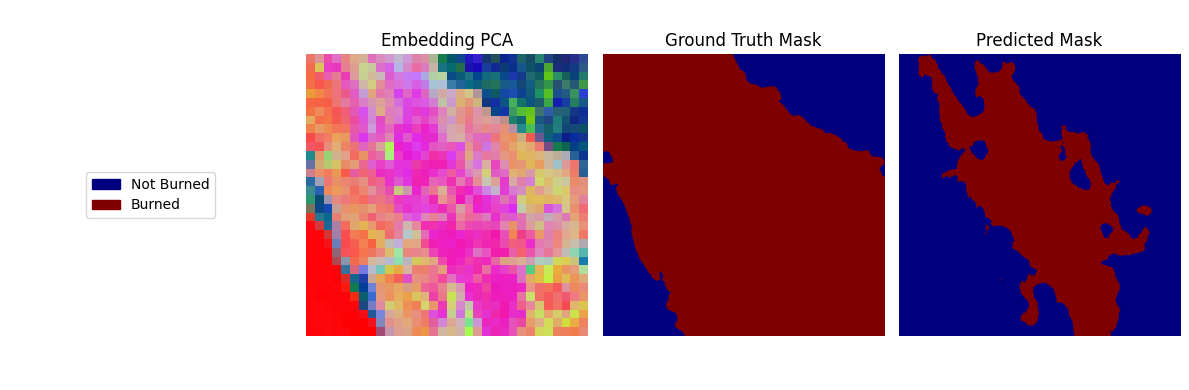

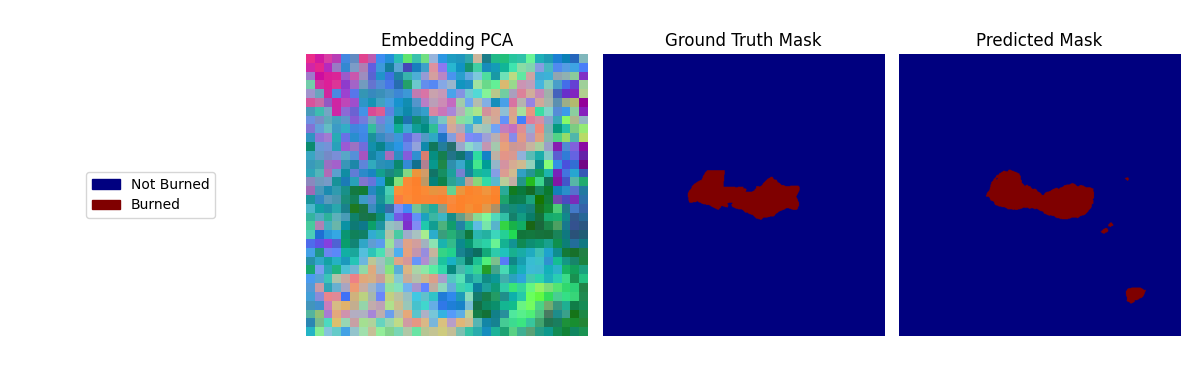

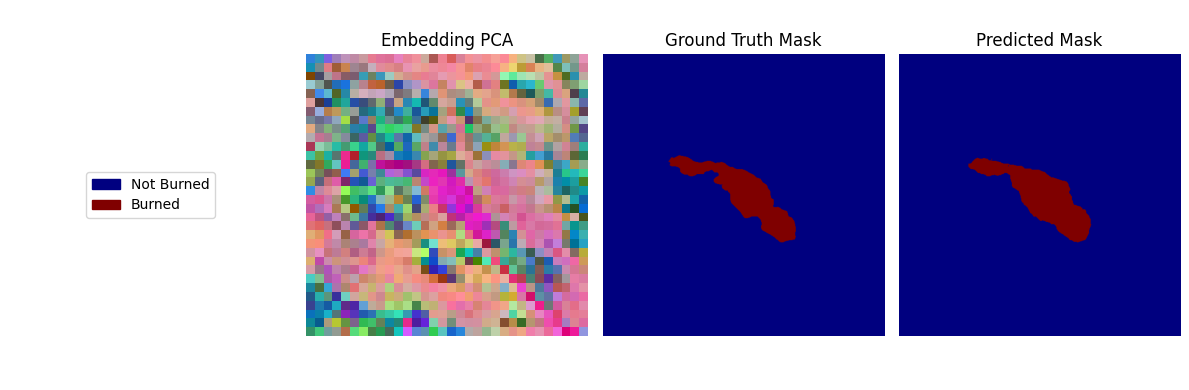

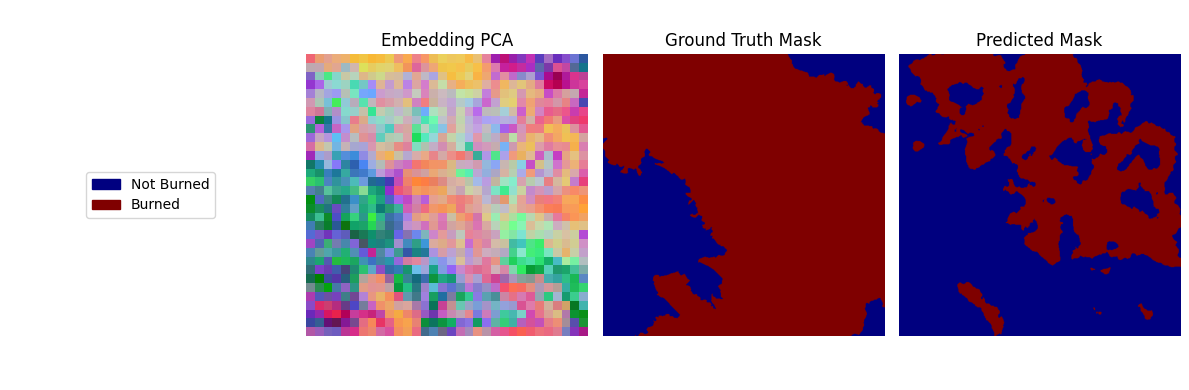

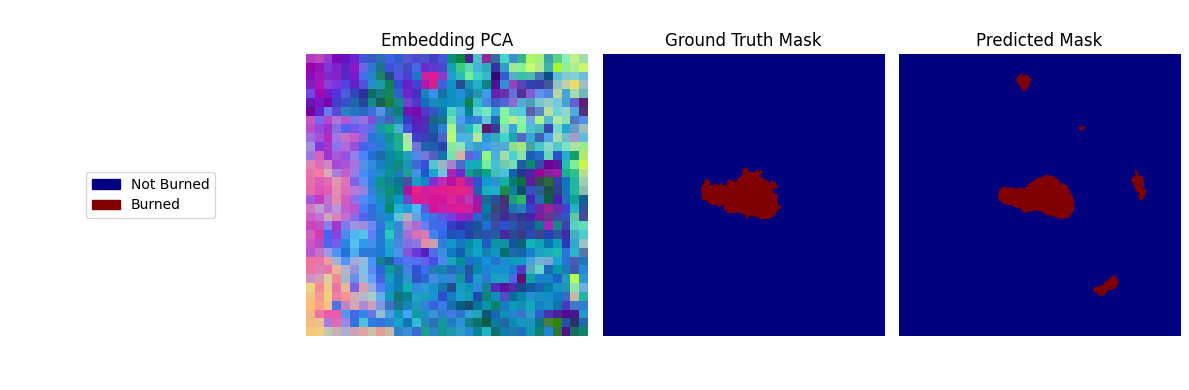

In [19]:
# Use the trained model for prediction and visualization
model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_factory=model.hparams.model_factory,
    model_args=model.hparams.model_args,
).to("cpu")

model.eval()

batch = next(iter(datamodule.test_dataloader()))

with torch.no_grad():
    outputs = model(batch["image"])
    preds = outputs.output.argmax(dim=1).cpu().numpy()

# Plot a few samples
for i in range(1,6):
    plot_sample({
        "image": batch["image"][i],
        "mask": batch["mask"][i],
        "prediction": preds[i],
    })

## Embedding Downstream Task via CLI

Above, we introduced the required TerraTorch components and how to combine them flexibly. The same workflow can be run in a no-code setup by configuring all components in a YAML file and executing it via the PyTorch Lightning CLI.

We provide a sample YAML that reproduces the workflow above and serves as a starting point for similar pipelines.

**Note:** You may want to restart the session to free up memory before running the CLI workflow.

In [ ]:
!terratorch fit -c downstream_segmentation_burnscars.yaml